<a href="https://colab.research.google.com/github/iranfromiran/computer-vision-brain-tumor/blob/main/ai_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchvision
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.models import resnet50
from torch.utils.data import random_split

from torchmetrics import Precision, Recall, F1Score
from sklearn.metrics import classification_report

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


import and preprocess the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/My Drive/Colab Notebooks/experiment data'
print("Training files:", os.listdir(os.path.join(data_dir, 'training')))
print("Testing files:", os.listdir(os.path.join(data_dir, 'testing')))

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

train_dir = '/content/drive/My Drive/Colab Notebooks/experiment data/training'
test_dir = '/content/drive/My Drive/Colab Notebooks/experiment data/testing'

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training files: ['glioma', 'pituitary', 'notumor', 'meningioma']
Testing files: ['glioma', 'notumor', 'meningioma', 'pituitary']


Sample image shape (after transform): torch.Size([1, 224, 224])
Label: 1


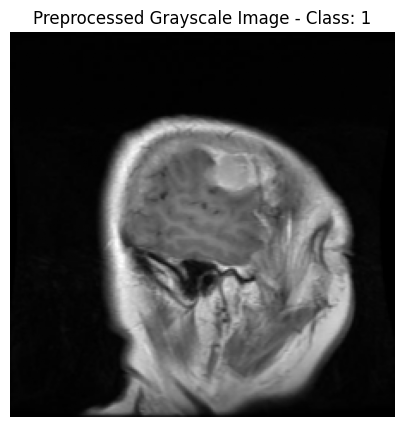

In [ ]:
# Verify preprocessing
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Multiply by std and add mean
    return tensor

sample_image, sample_label = train_dataset[0]
print("Sample image shape (after transform):", sample_image.shape)  # Should be [1, 224, 224]
print("Label:", sample_label)

denorm_image = denormalize(sample_image.clone(), mean=[0.485], std=[0.229])
denorm_image = denorm_image.squeeze(0).numpy()  # Remove channel dimension for grayscale

plt.figure(figsize=(5, 5))
plt.imshow(denorm_image, cmap='gray')
plt.title(f"Preprocessed Grayscale Image - Class: {sample_label}")
plt.axis('off')
plt.show()

In [ ]:
class ResNet50Grayscale(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNet50Grayscale, self).__init__()
        self.resnet = resnet50(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

model = ResNet50Grayscale(num_classes=4).to(device)

# Fine-tuning: Freeze early layers, train later layers
for param in model.resnet.conv1.parameters():
    param.requires_grad = False
for param in model.resnet.layer1.parameters():
    param.requires_grad = False
for param in model.resnet.layer2.parameters():
    param.requires_grad = False

print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet50Grayscale(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

Epoch [1/10], Step [10/22], Loss: 0.0204
Epoch [1/10], Step [20/22], Loss: 0.0462
Epoch [1/10] - Val Loss: 0.4110, Val Accuracy: 89.53%
Epoch [2/10], Step [10/22], Loss: 0.0518
Epoch [2/10], Step [20/22], Loss: 0.0973
Epoch [2/10] - Val Loss: 0.7219, Val Accuracy: 83.72%
Epoch [3/10], Step [10/22], Loss: 0.0975
Epoch [3/10], Step [20/22], Loss: 0.0646
Epoch [3/10] - Val Loss: 0.3853, Val Accuracy: 87.21%
Epoch [4/10], Step [10/22], Loss: 0.0242
Epoch [4/10], Step [20/22], Loss: 0.0344
Epoch [4/10] - Val Loss: 0.4564, Val Accuracy: 88.37%
Epoch [5/10], Step [10/22], Loss: 0.0408
Epoch [5/10], Step [20/22], Loss: 0.0070
Epoch [5/10] - Val Loss: 0.4890, Val Accuracy: 86.05%
Epoch [6/10], Step [10/22], Loss: 0.0170
Epoch [6/10], Step [20/22], Loss: 0.0288
Epoch [6/10] - Val Loss: 0.5417, Val Accuracy: 86.05%
Early stopping triggered!
Training Finished!


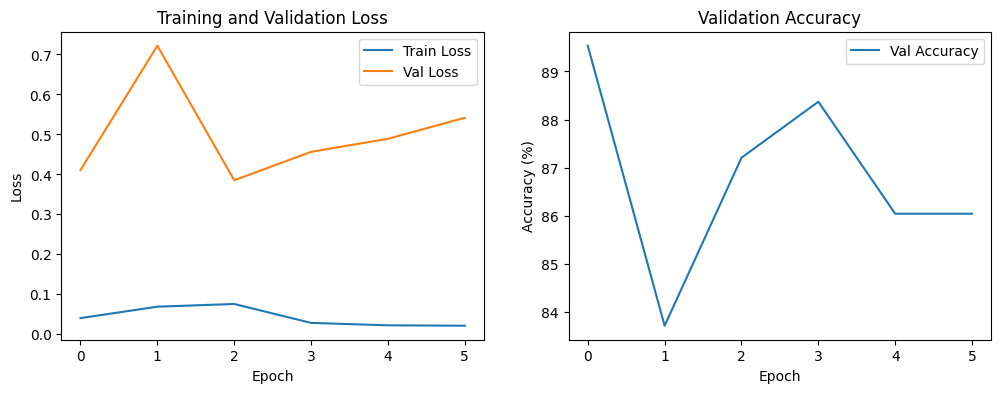

In [ ]:
#Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=0.001)  # Changed to Adam with lower lr for fine-tuning

# Training loop
num_epochs = 10

train_losses = []
val_losses = []
val_accuracies = []
best_val_loss = float('inf')
patience = 3
counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_train_loss += loss.item()
        if i % 10 == 9:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/10:.4f}')
            running_loss = 0.0

 # evaluation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}] - Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/resnet50_finetuned.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break
print('Training Finished!')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

In [ ]:
# Evaluatation
model.eval()
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

precision = Precision(task="multiclass", num_classes=4, average='macro').to(device)
recall = Recall(task="multiclass", num_classes=4, average='macro').to(device)
f1 = F1Score(task="multiclass", num_classes=4, average='macro').to(device)

all_preds_tensor = torch.tensor(all_preds).to(device)
all_labels_tensor = torch.tensor(all_labels).to(device)

prec_score = precision(all_preds_tensor, all_labels_tensor)
rec_score = recall(all_preds_tensor, all_labels_tensor)
f1_score = f1(all_preds_tensor, all_labels_tensor)

print(f'Precision (macro): {prec_score:.4f}')
print(f'Recall (macro): {rec_score:.4f}')
print(f'F1-score (macro): {f1_score:.4f}')

print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/resnet50_finetuned.pth')

Accuracy on test set: 80.61%
Precision (macro): 0.7964
Recall (macro): 0.7900
F1-score (macro): 0.7871

Detailed Classification Report:
              precision    recall  f1-score   support

      glioma       0.88      0.68      0.77        22
  meningioma       0.60      0.52      0.56        23
     notumor       0.86      1.00      0.92        30
   pituitary       0.85      0.96      0.90        23

    accuracy                           0.81        98
   macro avg       0.80      0.79      0.79        98
weighted avg       0.80      0.81      0.80        98

